# FNC 8.6 — Exercises 2, 3, 6 (Python Notebook)

This notebook answers the **programming** exercises from **FNC 8.6 — MINRES and conjugate gradients**.

- Written exercises **1, 4, 5** are answered in `习题解答/na_sol_datahub_8/main.tex`.

We use SciPy's iterative solvers and record residual histories for comparison with the bounds (8.6.2) and (8.6.4).


In [1]:
# If you're running locally and miss a dependency, uncomment the next line.
# %pip install --index-url https://pypi.org/simple numpy scipy matplotlib

import numpy as np
import matplotlib.pyplot as plt

from scipy import sparse
from scipy.sparse.linalg import minres, cg, eigsh


## Helpers: run MINRES/CG with residual tracking

In [2]:
def _matvec(A, x):
    return A @ x if not sparse.issparse(A) else A.dot(x)


def run_minres(A, b, *, maxiter: int, rtol: float = 0.0, M=None):
    b = np.asarray(b, dtype=float).reshape(-1)
    bnorm = float(np.linalg.norm(b))
    x0 = np.zeros_like(b)

    relhist = [float(np.linalg.norm(b - _matvec(A, x0))) / bnorm]

    def cb(xk):
        relhist.append(float(np.linalg.norm(b - _matvec(A, xk))) / bnorm)

    x, info = minres(A, b, x0=x0, rtol=rtol, maxiter=maxiter, M=M, callback=cb)
    return x, np.array(relhist), info


def run_cg(A, b, *, maxiter: int, rtol: float = 0.0, M=None):
    b = np.asarray(b, dtype=float).reshape(-1)
    bnorm = float(np.linalg.norm(b))
    x0 = np.zeros_like(b)

    relhist = [float(np.linalg.norm(b - _matvec(A, x0))) / bnorm]

    def cb(xk):
        relhist.append(float(np.linalg.norm(b - _matvec(A, xk))) / bnorm)

    x, info = cg(A, b, x0=x0, rtol=rtol, atol=0.0, maxiter=maxiter, M=M, callback=cb)
    return x, np.array(relhist), info


def anorm(A_diag, x):
    # A-norm for diagonal SPD A: ||x||_A = sqrt(x^T A x)
    return float(np.sqrt(np.sum(A_diag * (x**2))))


## Exercise 2 — MINRES on a diagonal indefinite matrix

We form A = diag([u; v]) with

- u = range(-200, -5, length=100)
- v = range(10, 100, length=100)

and b is a random unit vector of length 200.

Tasks:
- Run 120 MINRES iterations.
- Compute the relative error vs the exact solution (A is diagonal).
- Plot ||r_m||/||b|| and add the bound (8.6.2) (ignoring floor(m/2)).


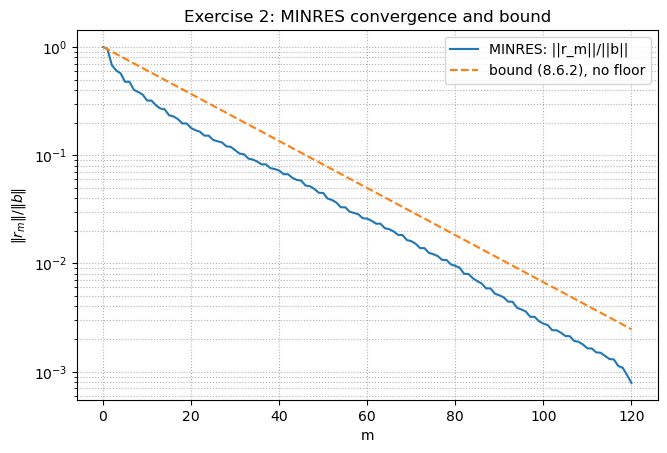

info = 120
relative error ||x-x*||/||x*|| = 0.0016282746647480837
kappa_plus = 10.0 kappa_minus = 40.0


In [3]:
rng = np.random.default_rng(123)

u = np.linspace(-200.0, -5.0, 100)
v = np.linspace(10.0, 100.0, 100)
diag = np.concatenate([u, v])
A = np.diag(diag)

b = rng.standard_normal(200)
b = b / np.linalg.norm(b)

x_true = b / diag

x, relhist, info = run_minres(A, b, maxiter=120, rtol=0.0)
relerr = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)

# bound (8.6.2)
pos = np.abs(v)
neg = np.abs(u)
kap_plus = float(pos.max() / pos.min())
kap_minus = float(neg.max() / neg.min())
ratio = (np.sqrt(kap_plus * kap_minus) - 1.0) / (np.sqrt(kap_plus * kap_minus) + 1.0)
ms = np.arange(len(relhist))
bound = ratio ** (ms / 2.0)  # ignore floor

plt.figure(figsize=(7.5, 4.8))
plt.semilogy(ms, relhist, label='MINRES: ||r_m||/||b||')
plt.semilogy(ms, bound, '--', label='bound (8.6.2), no floor')
plt.grid(True, which='both', ls=':')
plt.xlabel('m')
plt.ylabel(r'$\|r_m\|/\|b\|$')
plt.title('Exercise 2: MINRES convergence and bound')
plt.legend()
plt.show()

print('info =', info)
print('relative error ||x-x*||/||x*|| =', relerr)
print('kappa_plus =', kap_plus, 'kappa_minus =', kap_minus)


## Exercise 3 — MINRES vs CG on a diagonal SPD matrix

A is diagonal with entries in range(4,10000,length=500), and b is a random unit vector.

Tasks:
- Run 100 iterations of MINRES.
- Compute the relative A-norm error ||x_m - x||_A / ||x||_A (A is diagonal, so x is known).
- Plot ||r_m||/||b|| and add the bound (8.6.4).
- Add a CG convergence curve (100 iterations).


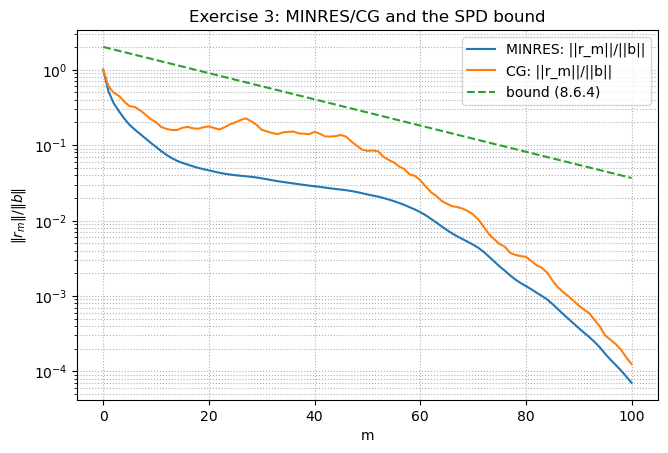

info (MINRES) = 100 info (CG) = 100
relative A-norm error (MINRES, m=100) = 0.00015689664756811148
kappa(A) = 2500.0


In [4]:
diag = np.linspace(4.0, 10000.0, 500)
A = np.diag(diag)

b = rng.standard_normal(500)
b = b / np.linalg.norm(b)

x_true = b / diag

x_mr, rel_mr, info_mr = run_minres(A, b, maxiter=100, rtol=0.0)
x_cg, rel_cg, info_cg = run_cg(A, b, maxiter=100, rtol=0.0)

errA = anorm(diag, x_mr - x_true) / anorm(diag, x_true)

kappa = float(diag.max() / diag.min())
ratio = (np.sqrt(kappa) - 1.0) / (np.sqrt(kappa) + 1.0)
ms = np.arange(len(rel_mr))
bound = 2.0 * (ratio ** ms)

plt.figure(figsize=(7.5, 4.8))
plt.semilogy(ms, rel_mr, label='MINRES: ||r_m||/||b||')
plt.semilogy(np.arange(len(rel_cg)), rel_cg, label='CG: ||r_m||/||b||')
plt.semilogy(ms, bound, '--', label='bound (8.6.4)')
plt.grid(True, which='both', ls=':')
plt.xlabel('m')
plt.ylabel(r'$\|r_m\|/\|b\|$')
plt.title('Exercise 3: MINRES/CG and the SPD bound')
plt.legend()
plt.show()

print('info (MINRES) =', info_mr, 'info (CG) =', info_cg)
print('relative A-norm error (MINRES, m=100) =', errA)
print('kappa(A) =', kappa)


## Exercise 6 — Helmholtz system: MINRES vs CG

We consider

\[ A = \mathrm{poisson}(n) - k^2 I, \quad b=-\mathbf{1}, \quad n=50. \]

To match the PDE-style Helmholtz scaling used in the text, we use the standard 5-point Laplacian
scaled by (n+1)^2:

\[ \mathrm{poisson}(n) = (n+1)^2 (I\otimes T + T\otimes I),\quad T=\operatorname{tridiag}(-1,2,-1). \]

Tasks:
- Solve to relative residual tolerance 1e-5 and plot MINRES vs CG for k=1.3 and k=8.
- Use eigenvalue estimates to diagnose definiteness for k=8.


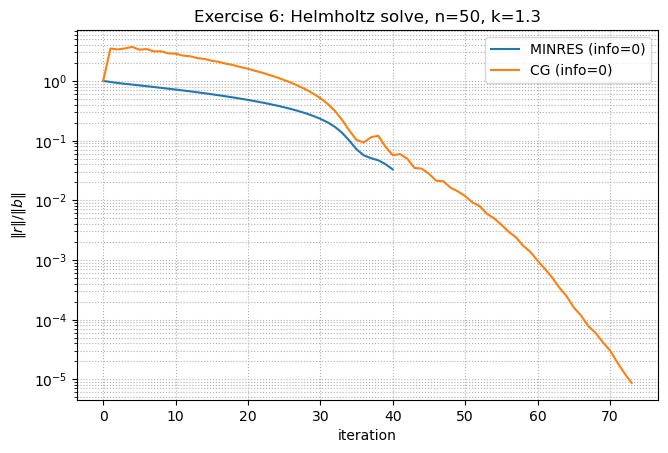

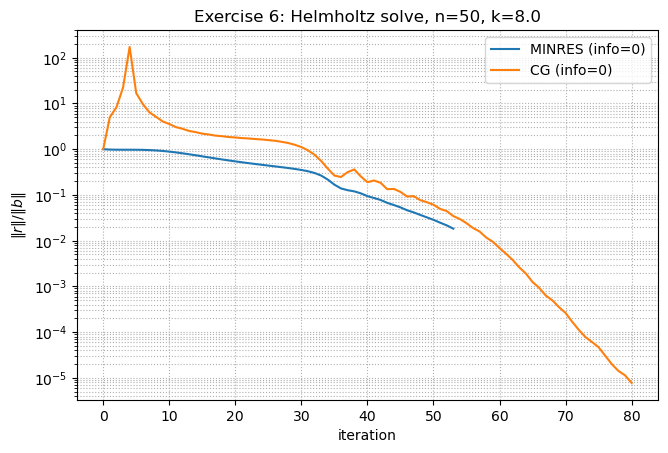

k=8: smallest eigenvalue ~ -44.26703218020564
k=8: largest  eigenvalue ~ 20724.26703218019
=> indefinite? True


In [5]:
def poisson_2d_scaled(n: int) -> sparse.csc_matrix:
    T = sparse.diags(
        diagonals=[-np.ones(n - 1), 2 * np.ones(n), -np.ones(n - 1)],
        offsets=[-1, 0, 1],
        format='csc',
    )
    I = sparse.identity(n, format='csc')
    P = sparse.kron(I, T) + sparse.kron(T, I)
    return ((n + 1) ** 2) * P


def helmholtz_matrix(n: int, k: float) -> sparse.csc_matrix:
    P = poisson_2d_scaled(n)
    return P - (k**2) * sparse.identity(n * n, format='csc')


def run_pair(n: int, k: float, *, rtol: float, maxiter: int = 500):
    A = helmholtz_matrix(n, k)
    b = -np.ones(n * n)

    x_mr, rel_mr, info_mr = run_minres(A, b, maxiter=maxiter, rtol=rtol)

    try:
        x_cg, rel_cg, info_cg = run_cg(A, b, maxiter=maxiter, rtol=rtol)
    except Exception as e:
        x_cg, rel_cg, info_cg = None, None, str(e)

    return A, (rel_mr, info_mr), (rel_cg, info_cg)


n = 50
rtol = 1e-5

for k in [1.3, 8.0]:
    A, (rel_mr, info_mr), (rel_cg, info_cg) = run_pair(n, k, rtol=rtol)

    plt.figure(figsize=(7.5, 4.8))
    plt.semilogy(rel_mr, label=f'MINRES (info={info_mr})')
    if rel_cg is not None:
        plt.semilogy(rel_cg, label=f'CG (info={info_cg})')
    else:
        plt.text(0.02, 0.2, f'CG failed: {info_cg}', transform=plt.gca().transAxes)
    plt.grid(True, which='both', ls=':')
    plt.xlabel('iteration')
    plt.ylabel(r'$\|r\|/\|b\|$')
    plt.title(f'Exercise 6: Helmholtz solve, n={n}, k={k}')
    plt.legend()
    plt.show()

# (c) definiteness check for k=8
A = helmholtz_matrix(n, 8.0)
lam_min = float(eigsh(A, k=1, which='SA', return_eigenvectors=False)[0])
lam_max = float(eigsh(A, k=1, which='LA', return_eigenvectors=False)[0])
print('k=8: smallest eigenvalue ~', lam_min)
print('k=8: largest  eigenvalue ~', lam_max)
print('=> indefinite?' , (lam_min < 0 < lam_max))
